In [2]:
from src.conv_seq2seq import *
from src.utils import *
from src.layers import MaskedCrossEntropyLoss
import torch 
import torch.optim as optim
import random

# Setup

In [3]:
# OPTIONS: 
# ENGLISH - en, 
# GERMAN - de, 
# FRENCH - fr, 
# CZECH - cs

lang1 = 'de'
lang2 = 'en'

train_sentences, test_sentences = load_data(lang1, lang2)
train_sentences = (train_sentences[0][:500], train_sentences[1][:500])

In [4]:
TEST_SIZE=0.2
BATCH_SIZE=64
VALID_BATCH_SIZE=128
MAX_VOCAB=20000

src_vocab, tgt_vocab, train_loader, valid_loader = make_dataset(train_sentences, test_sentences, BATCH_SIZE, VALID_BATCH_SIZE, MAX_VOCAB)

In [5]:
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(valid_loader.dataset)}")
print(f"Training Batches {len(train_loader)}\tValidation Batches {len(valid_loader)}")

Number of training examples: 500
Number of validation examples: 1014
Training Batches 8	Validation Batches 8


In [6]:
print(f"Unique tokens in source ({lang1}) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target ({lang2}) vocabulary: {len(tgt_vocab)}")

Unique tokens in source (de) vocabulary: 1348
Unique tokens in target (en) vocabulary: 1224


# Make the Model

In [174]:
# ENCODER ARGS
ENC_UNITS = 32 # 512
ENC_EMBEDDING = 32 # 256
SRC_VOCAB_SIZE = len(src_vocab)
ENC_NUM_LAYERS = 10 # 10
ENC_KERNEL_SIZE = 3 # ODD
DROPOUT = 0.25

# DECODER ARGS
DEC_UNITS = ENC_UNITS
DEC_EMBEDDING = ENC_EMBEDDING
TGT_VOCAB_SIZE = len(tgt_vocab)
DEC_NUM_LAYERS = ENC_NUM_LAYERS
DEC_KERNEL_SIZE = 3 # EVEN OR ODD
PAD_IDX = tgt_vocab.PAD_token


# SEQ2SEQ ARGS
MAX_LENGTH = max(train_loader.dataset.tensors[1].size(1), train_loader.dataset.tensors[0].size(1)) + 3
SOS_TOKEN = tgt_vocab.SOS_token
TEACHER_FORCING = 1.0

In [175]:
encoder = Encoder(SRC_VOCAB_SIZE, ENC_EMBEDDING, ENC_UNITS, ENC_NUM_LAYERS, ENC_KERNEL_SIZE, DROPOUT, MAX_LENGTH)
decoder = Decoder(DEC_UNITS, DEC_EMBEDDING, TGT_VOCAB_SIZE, DEC_NUM_LAYERS, DEC_KERNEL_SIZE, DROPOUT, PAD_IDX, MAX_LENGTH)

seq2seq = Seq2Seq(encoder, decoder, TEACHER_FORCING, MAX_LENGTH, SOS_TOKEN)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 256,328 trainable parameters


In [176]:
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (token_embedding): Embedding(1348, 32)
    (position_embedding): Embedding(49, 32)
    (embed2hidden): Linear(in_features=32, out_features=32, bias=True)
    (hidden2embed): Linear(in_features=32, out_features=32, bias=True)
    (convs): Sequential(
      (0): EncoderConv(
        (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (1): EncoderConv(
        (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (2): EncoderConv(
        (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (3): EncoderConv(
        (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (4): EncoderConv(
        (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,

In [177]:
criterion = MaskedCrossEntropyLoss(pad_tok=tgt_vocab.PAD_token)
optimizer = optim.Adam(seq2seq.parameters())

# Train

In [178]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)

In [179]:
# valid_loss

In [180]:
idx = 55
src_sentence = train_loader.dataset.tensors[0][idx:idx+1][:, :20]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1][:, :20]
print(src_sentence[:, :19])
print(tgt_sentence[:, :21])
print(src_sentence.size(), tgt_sentence.size())
print(src_vocab.to_string(src_sentence))
print(tgt_vocab.to_string(tgt_sentence))

tensor([[  2,   5,  12,   8,   7, 177,  70,  26,  19, 117, 579, 148,   6,  16,
         300,  18, 177, 151,   3]])
tensor([[  3,   2,   9,   6,   2, 139,  10,  77, 345,  16, 135, 592,  14, 317,
          81,   6,   2, 139,   5,   4]])
torch.Size([1, 20]) torch.Size([1, 20])
['<sos> ein mann in einem anzug rennt an zwei anderen herren vorbei , die auch einen anzug tragen . <eos>']
['<sos> a man in a suit is running past two other gentleman , also dressed in a suit . <eos>']


In [181]:
out, attention = seq2seq(src_sentence)

In [182]:
out.size(), attention.size()

(torch.Size([1, 49, 1224]), torch.Size([1, 49, 20]))

In [183]:
translation = tgt_vocab.to_string(out.argmax(dim=-1))[0]
translation

'someone paintbrush sweatshirt wearing hide jars adults top wearing river barefooted noddles jars someone gathering noddles jars covered police noddles adults skirt police wearing jars noddles hide toy someone having heavy she wearing flowers gathering police wedding heavy adults clutch skirt noddles surprised red lays adults adults jars leading'

In [184]:
N_EPOCHS = 50
CLIP = 1

# seq2seq.teacher_forcing = 1.0

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    
    train_loss = train(seq2seq, train_loader, optimizer, criterion, CLIP, src_vocab.PAD_token)
    valid_loss = evaluate(seq2seq, train_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'models/seq2seq_conv.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01








  0%|          | 0/8 [00:00<?, ?it/s]







 12%|█▎        | 1/8 [00:08<00:57,  8.16s/it]







 25%|██▌       | 2/8 [00:14<00:44,  7.48s/it]







 38%|███▊      | 3/8 [00:19<00:34,  6.99s/it]







 50%|█████     | 4/8 [00:27<00:28,  7.07s/it]







 62%|██████▎   | 5/8 [00:36<00:23,  7.68s/it]







 75%|███████▌  | 6/8 [00:43<00:14,  7.41s/it]







 88%|████████▊ | 7/8 [00:49<00:07,  7.11s/it]







100%|██████████| 8/8 [00:54<00:00,  6.58s/it]







  0%|          | 0/8 [00:00<?, ?it/s]







 12%|█▎        | 1/8 [00:01<00:13,  1.94s/it]







 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]







 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]







 50%|█████     | 4/8 [00:07<00:07,  1.94s/it]







 62%|██████▎   | 5/8 [00:09<00:05,  1.91s/it]







 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]







 88%|████████▊ | 7/8 [00:13<00:01,  1.94s/it]







100%|██████████| 8/8 [00:15<00:00,  1.80s/it]	Train Loss: 7.077 | Train PPL: 1184.509
	 Val. Loss

KeyboardInterrupt: 

In [113]:
def evaluate_translate(model, iterator, criterion, pad_tok=0):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, tgt) in enumerate(tqdm(iterator, file=sys.stdout)):
            # src.shape = (batch_size, src_seq_len)
            # tgt.shape = (batch_size, tgt_seq_len)
            src_mask = create_padding_mask(src, pad_tok)

            if model.type == 'rnn':
                output, attention = model(src, None, src_mask) #turn off teacher forcing
                # output.shape == (batch_size, max_length, tgt_vocab_size)
                # print(output)
                # output = output[:, 1:, :]
                tgt = tgt[:, 1:]
            elif model.type == 'conv':
                output, attention = model(src, None) #turn off teacher forcing
                tgt = tgt[:, 1:]

            loss = criterion(output, tgt) # masked loss automatically slices for you

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [114]:
valid_loss = evaluate_translate(seq2seq, train_loader, criterion)






  0%|          | 0/8 [00:00<?, ?it/s]




 12%|█▎        | 1/8 [00:03<00:21,  3.12s/it]




 25%|██▌       | 2/8 [00:06<00:19,  3.23s/it]




 38%|███▊      | 3/8 [00:09<00:16,  3.23s/it]




 50%|█████     | 4/8 [00:13<00:12,  3.23s/it]




 62%|██████▎   | 5/8 [00:16<00:09,  3.20s/it]




 75%|███████▌  | 6/8 [00:19<00:06,  3.18s/it]




 88%|████████▊ | 7/8 [00:22<00:03,  3.18s/it]




100%|██████████| 8/8 [00:25<00:00,  2.98s/it]

In [119]:
valid_loss, math.exp(valid_loss)

(0.8958491086959839, 2.4494147260598007)

In [153]:
idx = 0

src_sentence = train_loader.dataset.tensors[0][idx:idx+1]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1]

src_sentence = src_vocab.to_string(src_sentence, remove_special=True)[0]
tgt_sentence = tgt_vocab.to_string(tgt_sentence, remove_special=True)[0]

In [154]:
translation, attention = translate(src_sentence, seq2seq, src_vocab, tgt_vocab, src_vocab.PAD_token)

tensor([[  2,  19,  21,  29,  32,  35, 146,  17,  57,   8,  15,  58, 478, 479,
           3,   4]])
tensor([[35, 22,  5,  4,  5,  4,  5,  5,  4,  5,  5,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4]])


In [155]:
print(f"> {src_sentence}")
print(f"= {tgt_sentence}")
print(f"< {translation}")

> zwei junge wei e manner sind im freien in der nahe vieler busche .
= two young , white males are outside near many bushes .
< men boy . . . . . .


In [156]:
src_vocab.PAD_token

0

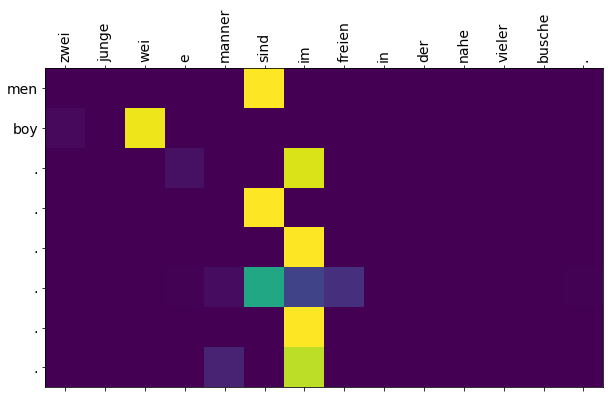

In [157]:
plot_attention(attention, src_sentence, translation)

In [55]:
attention

tensor([[4.3664e-11, 1.0312e-04, 1.2130e-21, 3.2909e-11, 1.0098e-01, 4.4736e-09,
         1.2194e-10, 8.9715e-10, 2.9493e-08, 2.2802e-06, 3.1995e-07, 1.0730e-09,
         5.1280e-10, 8.9890e-01, 1.6924e-05],
        [1.2821e-07, 2.2048e-11, 2.5935e-09, 8.2775e-04, 9.6637e-01, 1.8144e-03,
         3.6247e-08, 2.3610e-04, 2.4396e-05, 4.4837e-04, 2.9789e-02, 6.7302e-11,
         3.1570e-04, 1.6431e-04, 1.5167e-10],
        [9.7672e-09, 6.2471e-34, 8.9530e-07, 1.5813e-14, 3.4575e-20, 6.9667e-19,
         5.8963e-15, 1.4152e-18, 6.0852e-06, 5.0482e-12, 5.8400e-28, 2.9403e-39,
         4.2869e-13, 4.5173e-11, 9.9999e-01],
        [3.0974e-24, 6.0256e-44, 0.0000e+00, 3.3918e-30, 1.8024e-25, 8.6161e-30,
         1.4547e-22, 8.9977e-25, 8.0511e-24, 3.4063e-20, 2.0275e-40, 0.0000e+00,
         2.0891e-32, 7.1727e-18, 1.0000e+00],
        [8.9777e-29, 0.0000e+00, 0.0000e+00, 1.0618e-32, 7.0668e-37, 3.0974e-39,
         2.0014e-30, 1.1380e-33, 3.5251e-30, 6.0993e-26, 0.0000e+00, 0.0000e+00,
      

In [ ]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)